# Tutorial: Automated Procedures to Optimize the Decision Threshold for Imbalanced Classification

### Outlook

[Import Libraries](#section0) <br>

1. [Functions](#section1)

    1.1 [Functions to prepare the datasets and generate the fingerprints](#section1.1) <br>
    1.2 [Functions to calculate output metrics](#section1.2) <br>
    1.3 [Functions to optimize the decision threhold](#section1.3) <br>
    1.3.1 [Optimize the decision threshold using the prediction probabilities of the out-of-bag (oob) set](#section1.3.1) <br>
    1.3.2 [Generalized procedure to optimize the decision threshold](#section1.3.2) <br>
    1.4 [Functions to run other rebalancing approaches: RUS, SMOTE, and balanced random forest](#section1.4) <br>
    1.5 [Functions for Conformal Prediction](#section1.5) <br>
    1.6 [Function to run everything and store the results into an archive](#section1.6) <br>
    
    
2. [Run Examples](#section2)

    2.1 [Read Data for the Serotonin Datasets](#section2.1)<br>
    2.2 [Run the code (run_it function) step by step for a single serotonin dataset](#section2.2)<br>
    2.3 [Run the `run_it_` function for a single serotonin dataset](#section2.3)<br>
    2.4 [Run the `run_it_` function for all serotonin datasets](#section2.4)<br>
   
   
3. [Plot Results](#section3)<br>

<a id='section0'></a>

### Import Libraries

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem
from rdkit import SimDivFilters
from rdkit.Chem.MolStandardize import rdMolStandardize

from collections import defaultdict
import pandas as pd
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator

In [2]:
from sklearn.model_selection import train_test_split
import sklearn
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from imblearn.ensemble import BalancedRandomForestClassifier

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6

In [3]:
# only print out critical error messages of rdkit
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

<a id='section1'></a>

# 1. Functions

<a id='section1.1'></a>

### 1.1 Functions to prepare the datasets and generate the fingerprints

In [4]:
# Remove counterions: Take the largest organic fragment
def salt_remover(smiles):
    rmv = rdMolStandardize.LargestFragmentChooser()
    cleaned_smiles = []
    for smi in smiles:
        if "." in smi:
            cleaned_smiles.append(Chem.MolToSmiles(rmv.choose(Chem.MolFromSmiles(smi))))
        else:
            cleaned_smiles.append(smi)
    return cleaned_smiles



# Compute the ECFP4 fingerprint with 2048 bits
def add_MorganFP(acts):
    act_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in acts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        act_data.append(bv)
    acts['MorganFP'] = act_data
    return(acts)


# Compute the RDKit2D fingerprint (200 topological properties) using the descriptastorus library
def add_rdkit2d(acts, smiles_column = 'canonical_smiles'):
    if smiles_column not in list(acts):
        print("Error: the column {} is not contained in the input dataframe. A column containing SMILES is required to calculate property-based fingerprints".format(smiles_column))
        return(acts)
    acts[smiles_column] = acts[smiles_column].astype(str)
    rdkit2d = []
    generator = MakeGenerator(("RDKit2D",))
    for n, smi in enumerate(acts[smiles_column]):
        try:
            data = generator.process(smi)
            if data[0] == True:
                data.pop(0)
            if data[0] == False:
                data.pop(0)
            data = np.float32(data)
            data[np.isposinf(data)] = np.finfo('float32').max
            data[np.isneginf(data)] = np.finfo('float32').min
            data = np.nan_to_num(data)
            rdkit2d.append(list(data))
        except:
            rdkit2d.append([0]*200)
            print("Error: RDKit2D not generated for {}".format(acts['compound_chembl_id'][n]))
    acts['RDKit2D'] = rdkit2d
    return(acts)


def gen_fps(acts,inacts, descriptor = 'MorganFP'):
    # generate fingerprints for the actives and inactives and convert them to numpy arrays so that
    # we can learn from them. This uses the generalized fingerprinter added in the RDKit 2018.09 release
    labels_column = 'labels'
    if descriptor == 'RDKit2D':
        acts = add_rdkit2d(acts)
        inacts = add_rdkit2d(inacts)
    if descriptor == 'MorganFP':
        acts = add_MorganFP(acts)
        inacts = add_MorganFP(inacts)
    acts[labels_column] = 1
    inacts[labels_column] = 0
    df_dataset = pd.concat((acts, inacts))
    df_dataset.reset_index(inplace = True, drop = True)
    # exclude the compounds for which RDKit2D could not be completely calculated
    if descriptor == 'RDKit2D':
        check_idx = [i for i,a in enumerate(list(df_dataset[descriptor])) if len(a) != 200]
        df_dataset.drop(check_idx, inplace=True) 
    return df_dataset



<a id='section1.2'></a>

### 1.2 Function to calculate output metrics

In [5]:
def calc_metrics(labels_test, test_probs, threshold = 0.5):
    scores = [1 if x>=threshold else 0 for x in test_probs]
    auc = metrics.roc_auc_score(labels_test, test_probs)
    kappa = metrics.cohen_kappa_score(labels_test,scores)
    confusion = metrics.confusion_matrix(labels_test,scores, labels=list(set(labels_test)))
    print('thresh: %.2f, kappa: %.3f, AUC test-set: %.3f'%(threshold, kappa, auc))
    print(confusion)
    print(metrics.classification_report(labels_test,scores))
    return kappa, confusion, auc



<a id='section1.3'></a>

### 1.3 Functions to optimize the decision threhold

<a id='section1.3.1'></a>
#### 1.3.1 Optimize the decision threshold using the prediction probabilities of the out-of-bag (oob) set 
This approach has been described [here](http://rdkit.blogspot.com/2018/11/working-with-unbalanced-data-part-i.html) and can only be used for the random forest classifier.

The function below requires as input:
- `oob_probs`: the oob active prediction probabilities, which can be extracted from the trained RF model (cls) as 

        oob_probs = cls.oob_decision_function_
        oob_probs = [x[1] for x in oob_probs]
        
- `labels_train`: the true labels of the training set 
- `thresholds`: list a thresholds (e.g. [0.1, 0.2, 0.3, 0.4, 0.5])

To optmize the decision threshold, one can use different metrics. 
Here, you can select `ThOpt_metrics = 'Kappa'`, `'ROC'`, or `'ROC_Song14'`.

With, `ThOpt_metrics = 'Kappa'`, the Cohen's Kappa is calculated for the oob set and a range of thresholds (specified using the threshold argument). The optimal threshold (returned) is the one that maximizes the Cohen's Kappa.

The threshold optimization based on the ROC curve is described [here](https://doi.org/10.1007/s11548-013-0913-8). With, `ThOpt_metrics = 'ROC'`, sensitivity and specificity are calculated for a range of thresholds using the roc_curve function of scikit-learn. The optimal threshold (returned) is the one that minimizes the distance to the [0,1] corner of the ROC plot. 

In [6]:
def run_it_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics = 'Kappa'):
    """Optimize the decision threshold based on the prediction probabilities of the out-of-bag set of random forest.
    The threshold that maximizes the Cohen's kappa coefficient or a ROC-based criterion 
    on the out-of-bag set is chosen as optimal.
    
    Parameters
    ----------
    oob_probs : list of floats
        Positive prediction probabilities for the out-of-bag set of a trained random forest model
    labels_train: list of int
        True labels for the training set
    thresholds: list of floats
        List of decision thresholds to screen for classification
    ThOpt_metrics: str
        Optimization metric. Choose between "Kappa" and "ROC"
        
    Returns
    ----------
    thresh: float
        Optimal decision threshold for classification
    """
    # Optmize the decision threshold based on the Cohen's Kappa coefficient
    if ThOpt_metrics == 'Kappa':
        tscores = []
        # evaluate the score on the oob using different thresholds
        for thresh in thresholds:
            scores = [1 if x>=thresh else 0 for x in oob_probs]
            kappa = metrics.cohen_kappa_score(labels_train,scores)
            tscores.append((np.round(kappa,3),thresh))
        # select the threshold providing the highest kappa score as optimal
        tscores.sort(reverse=True)
        thresh = tscores[0][-1]
    # Optmize the decision threshold based on the ROC-curve
    elif ThOpt_metrics == 'ROC':
        # ROC optimization with thresholds determined by the roc_curve function of sklearn
        fpr, tpr, thresholds_roc = metrics.roc_curve(labels_train, oob_probs, pos_label=1)
        specificity = 1-fpr
        roc_dist_01corner = (2*tpr*specificity)/(tpr+specificity)
        thresh = thresholds_roc[np.argmax(roc_dist_01corner)]
    return thresh



<a id='section1.3.2'></a>

#### 1.3.2 GHOST: Generalized procedure to optimize the decision threshold
The function below utilizes the prediction probabilities of N training subsets (`N_subsets`) to optimize the classification threshold. The subsets can be drawn with or without replacement (`with_replacement`). The subset size can be selected using the `subset_size` argument (default = 0.2), which, if float, represents the proportion of the dataset to include in the subset. If integer, it represents the actual number of instances to include in the subset. As for the previous function, two optimization metrics are available `ThOpt_metrics = 'Kappa'` or `ThOpt_metrics = 'ROC'`.

Required inputs are:
- `cls`: trained classification model
- `fps_train`: numpy array of descriptors of the training set
- `labels_train`: list of true labels for the training set
- `thresholds`: list a thresholds (e.g. [0.1, 0.2, 0.3, 0.4, 0.5])


In [7]:
def optimize_threshold_train_subset(cls, fps_train, labels_train, thresholds, 
                                    ThOpt_metrics = 'Kappa', N_subsets = 100, 
                                    subsets_size = 0.2, with_replacement = False, random_seed = None):

    """Optimize the decision threshold based on subsets of the training set.
    The threshold that maximizes the Cohen's kappa coefficient or a ROC-based criterion 
    on the training subsets is chosen as optimal.
    
    Parameters
    ----------
    cls : obj
        Trained machine learning classifier built using scikit-learn
    fps_train: list 
        Molecular descriptors for the training set
    labels_train: list of int
        True labels for the training set
    thresholds: list of floats
        List of decision thresholds to screen for classification
    ThOpt_metrics: str
        Optimization metric. Choose between "Kappa" and "ROC"
    N_subsets: int
        Number of training subsets to use in the optimization
    subsets_size: float or int
        Size of the subsets. if float, represents the proportion of the dataset to include in the subsets. 
        If integer, it represents the actual number of instances to include in the subsets. 
    with_replacement: bool
        The subsets are drawn randomly. True to draw the subsets with replacement
    random_seed: int    
        random number to seed the drawing of the subsets
    
    Returns
    ----------
    thresh: float
        Optimal decision threshold for classification
    """
    
    # seeding
    np.random.seed(random_seed)
    random_seeds = np.random.randint(N_subsets*10, size=N_subsets)  
    
    # calculate prediction probability for the training set
    probs_train = cls.predict_proba(fps_train)[:,1]
    labels_train_thresh = {'labels': labels_train}
    labels_train_thresh.update({'probs': probs_train})
    # recalculate the predictions for the training set using different thresholds and
    # store the predictions in a dataframe
    for thresh in thresholds:
        labels_train_thresh.update({str(thresh): [1 if x >= thresh else 0 for x in probs_train]})
    df_preds = pd.DataFrame(labels_train_thresh)
    # Optmize the decision threshold based on the Cohen's Kappa coefficient
    if ThOpt_metrics == 'Kappa':
        # pick N_subsets training subsets and determine the threshold that provides the highest kappa on each 
        # of the subsets
        kappa_accum = []
        for i in range(N_subsets):
            if with_replacement:
                if isinstance(subsets_size, float):
                    Nsamples = int(df_preds.shape[0]*subsets_size)
                elif isinstance(subsets_size, int):
                    Nsamples = subsets_size                    
                df_subset = resample(df_preds, n_samples = Nsamples, stratify=list(df_preds.labels), random_state = random_seeds[i])
                labels_subset = df_subset['labels']
            else:
                df_tmp, df_subset, labels_tmp, labels_subset = train_test_split(df_preds, labels_train, test_size = subsets_size, stratify = labels_train, random_state = random_seeds[i])
            probs_subset = list(df_subset['probs'])
            thresh_names = [x for x in df_preds.columns if (x != 'labels' and x != 'probs')]
            kappa_train_subset = []
            for col1 in thresh_names:
                kappa_train_subset.append(metrics.cohen_kappa_score(labels_subset, list(df_subset[col1])))
            kappa_accum.append(kappa_train_subset)
        # determine the threshold that provides the best results on the training subsets
        y_values_median, y_values_std = helper_calc_median_std(kappa_accum)
        opt_thresh = thresholds[np.argmax(y_values_median)]
    # Optmize the decision threshold based on the ROC-curve, as described here https://doi.org/10.1007/s11548-013-0913-8
    elif ThOpt_metrics == 'ROC':
        sensitivity_accum = []
        specificity_accum = []
        # Calculate sensitivity and specificity for a range of thresholds and N_subsets
        for i in range(N_subsets):
            if with_replacement:
                if isinstance(subsets_size, float):
                    Nsamples = int(df_preds.shape[0]*subsets_size)
                elif isinstance(subsets_size, int):
                    Nsamples = subsets_size                    
                df_subset = resample(df_preds, n_samples = Nsamples, stratify=list(df_preds.labels), random_state = random_seeds[i])
                labels_subset = list(df_subset['labels'])
            else:
                df_tmp, df_subset, labels_tmp, labels_subset = train_test_split(df_preds, labels_train, test_size = subsets_size, stratify = labels_train, random_state = random_seeds[i])
            probs_subset = list(df_subset['probs'])
            sensitivity = []
            specificity = []
            for thresh in thresholds:
                scores = [1 if x >= thresh else 0 for x in probs_subset]
                tn, fp, fn, tp = metrics.confusion_matrix(labels_subset, scores, labels=list(set(labels_train))).ravel()
                sensitivity.append(tp/(tp+fn))
                specificity.append(tn/(tn+fp))
            sensitivity_accum.append(sensitivity)
            specificity_accum.append(specificity)
        # determine the threshold that provides the best results on the training subsets
        median_sensitivity, std_sensitivity = helper_calc_median_std(sensitivity_accum)
        median_specificity, std_specificity = helper_calc_median_std(specificity_accum)
        roc_dist_01corner = (2*median_sensitivity*median_specificity)/(median_sensitivity+median_specificity)
        opt_thresh = thresholds[np.argmax(roc_dist_01corner)]
    return opt_thresh


def helper_calc_median_std(specificity):
    # Calculate median and std of the columns of a pandas dataframe
    arr = np.array(specificity)
    y_values_median = np.median(arr,axis=0)
    y_values_std = np.std(arr,axis=0)
    return y_values_median, y_values_std    





<a id='section1.4'></a>

### 1.4 Functions to run other rebalancing approaches: RUS, SMOTE, and balanced random forest

Functions implemented in the [imbalanced-learn](https://imbalanced-learn.org/stable/index.html) library are used.

In [8]:
def run_smote(fps_train, fps_test, labels_train, labels_test, **kwargs):
    oversample = SMOTE()
    fps_train_os, labels_train_os = oversample.fit_resample(fps_train, labels_train)
    # build the classification model:
    cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4,oob_score=True, **kwargs)
    cls.fit(fps_train_os, labels_train_os)
    probs = cls.predict_proba(fps_test)[:,1]
    return cls, probs 


def run_random_undersampling(fps_train, fps_test, labels_train, labels_test, **kwargs):
    rus = RandomUnderSampler()
    fps_train_rus, labels_train_rus = rus.fit_resample(fps_train, labels_train)
    # build the classification model:
    cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4,oob_score=True, **kwargs)
    cls.fit(fps_train_rus, labels_train_rus)
    probs = cls.predict_proba(fps_test)[:,1]
    return cls, probs 


def run_balancedRF(fps_train, fps_test, labels_train, labels_test, **kwargs):
    # build the classification model:
    cls = BalancedRandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4, **kwargs)
    cls.fit(fps_train, labels_train)
    probs = cls.predict_proba(fps_test)[:,1]
    return cls, probs 
    

<a id='section1.5'></a>

### 1.5 Functions for Conformal Prediction

The [nonconformist](https://github.com/donlnz/nonconformist) library is used. The functions below were adapted from the [code](https://github.com/volkamerlab/knowtox_manuscript_SI) of the Volkamer lab (see also [this Ref](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00422-x)).

In [9]:
from nonconformist.icp import IcpClassifier
from nonconformist.nc import InverseProbabilityErrFunc, NcFactory
from nonconformist.acp import AggregatedCp, RandomSubSampler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold

# function to train ML model and calibrate cross-validation ACP conformal predictor.
# Within each loop of a fivefold cross-validation, an ACP with 25 loops was generated. 
# In each ACP loop, training data was split into 70% proper training and 30% calibration data
def run_acp(fps, labels, cv_folds = 5, nc_normalization = True, N_acp_models = 25, 
            error_function = None, icp_classifier_condition = None, aggregation_function = None,
            random_seed = None, mol_names = None, **kwargs):
    
    # DEFAULT PARAMETERS FOR CP
    # error function
    if error_function == None:
        error_function = InverseProbabilityErrFunc()
    # ICP
    if icp_classifier_condition == None:
        icp_classifier_condition = (lambda instance: instance[1]) # Mondrian condition in conformal prediction
    # aggregation
    if aggregation_function == None:
        aggregation_function = (lambda x: np.median(x,axis=2)) # Function to aggregate p-values in ACP

    # Split data for crossvalidation
    kf = StratifiedKFold(n_splits=cv_folds, random_state=random_seed, shuffle=True)
    acps_cv = [] # Save all ACPs to use for further prediction
    
    # Define parameters for choosen CP model set-up: 
    # - acp_option: how to split the data into training and calibration set for each acp loop
    # - normaliser_model = True: normalize the nonconformity score by training a KNeighborsRegressor model
    if nc_normalization == False:
        normaliser_model = None
        acp_option = RandomSubSampler() #stratified random split. default calibration proportion 0.3
    elif nc_normalization == True:
        normaliser_model = KNeighborsRegressor()
        acp_option = RandomSubSampler() #stratified random split. default calibration proportion 0.3 

    # Fit model within crossvalidation and make prediction for respective calibration set
    df_output = pd.DataFrame()
    for train_index, calib_index in kf.split(fps, labels):
        # Prepare the data splits
        X_train, X_calib = fps[train_index], fps[calib_index]
        y_train, y_calib = labels[train_index], labels[calib_index]

        # Create and train model on training set
        cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4,oob_score=True, **kwargs)
        nc = NcFactory.create_nc(cls, err_func=error_function, normalizer_model=normaliser_model)
        icp = IcpClassifier(nc, condition=icp_classifier_condition)
        acp = AggregatedCp(n_models=N_acp_models, predictor=icp, sampler=acp_option,
                           aggregation_func=aggregation_function)
        acp.fit(X_train, y_train)
        acps_cv.append(acp)
        
        # Make predictions for calibration set
        predictions = acp.predict(X_calib)

        # Write p-values and further compound information for each split into output dataframe
        df_output_tmp = pd.DataFrame({'p0': list(predictions[:,0]), 'p1': list(predictions[:,1]), 
                                      'prediction': list(predictions), 'y_true': list(y_calib)})
        
        if isinstance(mol_names, (list,np.ndarray)) and len(mol_names) == len(labels):
            if isinstance(mol_names, list):
                mol_names = np.array(mol_names)
            mol_names_train, mol_names_calib = mol_names[train_index], mol_names[calib_index]
            df_output_tmp["mol_names"] = list(mol_names_calib)
            
        df_output = pd.concat((df_output, df_output_tmp))
    # save to csv file  
    #df_output.to_csv('conformal_predictions_calibration.csv', index = False)
    return acps_cv, df_output



def predict_acp_get_pvalues(acps_cv, fps_test, labels_test, mol_names = None):
    """
    Make conformal predictions for external test data and save p-values to dataframe
    """
    predict_df = pd.DataFrame()

    # With each of the ACPs trained in CV
    predictions_p0 = pd.DataFrame()
    predictions_p1 = pd.DataFrame()

    for i, a in enumerate(acps_cv):
        p = a.predict(fps_test)
        predictions_p0[i] = list(p[:,0])
        predictions_p1[i] = list(p[:,1])

    predict_df['p0'] = list(predictions_p0.median(axis=1))
    predict_df['p1'] = list(predictions_p1.median(axis=1))
    predict_df['y_true'] = list(labels_test)
    if mol_names != None and len(mol_names) == len(labels_test):
        predict_df['mol_names'] = list(mol_names)
        
    # save to csv file    
    #predict_df.to_csv('conformal_predictions_test.csv')
    return predict_df



#### 1.5.1 Evaluate conformal predictor <a name="evaluate-conformal-predictors"></a>

#### Define evaluation functions to calculate validity, efficiency, accuracy_rate, and accuracy
**Efficiency** = fraction of single class predictions, ignoring whether they are correct or not <br>
**Validity** = fraction of correct prediction, including uncertain (multi, [0,1]) predictions<br>
**Accuracy rate** = ratio between the number of correct single class predictions and the total number of single class predictions<br>
**Accuracy** = ratio between the number of correct single class predictions and the total number of predictions

In [10]:
def check_counts_rows(counts):
    if '0' not in list(counts.index):
        counts.loc['0'] = [0.0] * counts.shape[1]
    if '1' not in list(counts.index):
        counts.loc['1'] = [0.0] * counts.shape[1]
    if '[0,1]' not in list(counts.index):
        counts.loc['[0,1]'] = [0.0] * counts.shape[1]
    if '[,]' not in list(counts.index):
        counts.loc['[,]'] = [0.0] * counts.shape[1]
    return(counts)

def calc_CP_performance(predict_df, labels_column = 'y_true', significance_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    pd.options.mode.chained_assignment = None  # default='warn'
    for significance_level in significance_levels:
        predict_df['y_pred_{}'.format(significance_level)] = np.nan
        predict_df['y_pred_{}'.format(significance_level)][(predict_df['p0'] >= significance_level) & (predict_df['p1'] < significance_level)] = '0'
        predict_df['y_pred_{}'.format(significance_level)][(predict_df['p1'] >= significance_level) & (predict_df['p0'] < significance_level)] = '1'
        predict_df['y_pred_{}'.format(significance_level)][(predict_df['p0'] >= significance_level) & (predict_df['p1'] >= significance_level)] = '[0,1]'
        predict_df['y_pred_{}'.format(significance_level)][(predict_df['p0'] < significance_level) & (predict_df['p1'] < significance_level)] = '[,]'
    # Calculate metrics: efficiency, validity, accuracy_rate, and accuracy
    metrics_dict = {}
    metrics_dict['significance_level'] = significance_levels
    predict_df0 = predict_df.loc[predict_df['y_true'] == 0]
    predict_df1 = predict_df.loc[predict_df['y_true'] == 1]
    counts = predict_df[[s for s in list(predict_df.columns) if 'y_pred' in s]].apply(pd.Series.value_counts).fillna(0)
    counts_0 = predict_df0[[s for s in list(predict_df0.columns) if 'y_pred' in s]].apply(pd.Series.value_counts).fillna(0)
    counts_1 = predict_df1[[s for s in list(predict_df1.columns) if 'y_pred' in s]].apply(pd.Series.value_counts).fillna(0)
    counts = check_counts_rows(counts)
    counts_0 = check_counts_rows(counts_0)
    counts_1 = check_counts_rows(counts_1)
    if len(list(set(counts_0.sum()))) == 1 and len(list(set(counts_1.sum()))) == 1:
        metrics_dict['efficiency_0'] = (np.array(counts_0.loc['0']) + np.array(counts_0.loc['1']))/int(list(set(counts_0.sum()))[0])
        metrics_dict['efficiency_1'] = (np.array(counts_1.loc['0']) + np.array(counts_1.loc['1']))/int(list(set(counts_1.sum()))[0])
        metrics_dict['efficiency'] = (np.array(counts.loc['0']) + np.array(counts.loc['1']))/int(list(set(counts.sum()))[0])
        metrics_dict['validity_0'] = (np.array(counts_0.loc['0']) + np.array(counts_0.loc['[0,1]']))/int(list(set(counts_0.sum()))[0])
        metrics_dict['validity_1'] = (np.array(counts_1.loc['1']) + np.array(counts_1.loc['[0,1]']))/int(list(set(counts_1.sum()))[0])
        metrics_dict['validity'] = (np.array(counts_0.loc['0']) + np.array(counts_1.loc['1']) + np.array(counts.loc['[0,1]']))/int(list(set(counts.sum()))[0])
        metrics_dict['accuracy_rate_0'] = np.array(counts_0.loc['0'])/(np.array(counts_0.loc['0']) + np.array(counts_0.loc['1']))
        metrics_dict['accuracy_rate_1'] = np.array(counts_1.loc['1'])/(np.array(counts_1.loc['0']) + np.array(counts_1.loc['1']))
        metrics_dict['accuracy_rate'] = (np.array(counts_0.loc['0']) + np.array(counts_1.loc['1']))/(np.array(counts.loc['0']) + np.array(counts.loc['1']))
        metrics_dict['accuracy_0'] = np.array(counts_0.loc['0'])/predict_df0.shape[0]
        metrics_dict['accuracy_1'] = np.array(counts_1.loc['1'])/predict_df1.shape[0]
        metrics_dict['accuracy'] = (np.array(counts_0.loc['0']) + np.array(counts_1.loc['1']))/predict_df.shape[0]
    else:
        print('Error: There must be an error in the countings. \nThere are different number of predictions for the different significance levels')

    df_metrics = pd.DataFrame(metrics_dict)    
    return predict_df, df_metrics



Plot results of conformal prediction:

In [11]:
def plot_cp_results(predict_df, df_metrics, output_name = "test"):
    fig, axs = plt.subplots(2, 1, figsize = (6,8))
    fig.subplots_adjust(hspace=0.3)
    # plot validity and efficiency vs significance (error rate)
    axs[0].plot(df_metrics.significance_level, df_metrics.efficiency_0, c = 'red', label = 'efficiency_0')
    axs[0].plot(df_metrics.significance_level, df_metrics.efficiency_1, c = 'orange', label = 'efficiency_1')
    axs[0].plot(df_metrics.significance_level, df_metrics.validity_0, c = 'navy', label = 'validity_0')
    axs[0].plot(df_metrics.significance_level, df_metrics.validity_1, c = 'deepskyblue', label = 'validity_1')
    axs[0].set_ylabel("Metric", fontsize = 20)
    axs[0].set_xlabel("ACP Significance", fontsize = 20)
    axs[0].legend(loc='upper center', bbox_to_anchor=(1.25, 1), fontsize = 16, ncol = 1)
    axs[0].tick_params(labelsize = 16)
    # bar plot of predictions
    counts = predict_df[[s for s in list(predict_df.columns) if 'y_pred' in s]].apply(pd.Series.value_counts).fillna(0)
    counts.columns = [s.replace('y_pred_','') for s in counts.columns]
    counts.T.plot(kind="bar", ax=axs[1])
    axs[1].set_ylabel("N. of predictions", fontsize = 20)
    axs[1].set_xlabel("ACP Significance", fontsize = 20)
    axs[1].legend(loc='upper center', bbox_to_anchor=(1.17, 1), fontsize = 16, ncol = 1)
    axs[1].tick_params(labelsize = 16)
    #plt.savefig("./figures/CP_results_{}.png".format(output_name), dpi=600, bbox_inches='tight')


<a id='section1.6'></a>

### 1.6 Function to run everything and store the results into an archive

In [12]:
def run_it_(assay_id, acts, inacts, archive, descriptor = 'MorganFP', scale_features = False, 
            test_set_size = 0.2, random_seed = None, 
            opt_oob = False, ThOpt_metrics = 'Kappa', thresholds = None, N_subsets = None, 
            subsets_size = None, with_replacement = False, try_resampling = True, try_brf = False, 
            try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25, **kwargs):
    
    # clean data:
    acts['canonical_smiles'] = salt_remover(acts['canonical_smiles'])
    inacts['canonical_smiles'] = salt_remover(inacts['canonical_smiles'])
    
    # generate descriptors and split the data into a training and test set:
    df_dataset = gen_fps(acts,inacts, descriptor = descriptor)

    # return fps and true labels
    labels = np.array(list(df_dataset['labels']))
    fps = np.array(df_dataset[descriptor])
    fps = np.stack(fps, axis = 0)
     # retrieve compound IDs
    mol_names = list(df_dataset['compound_chembl_id']) 
    
    # scale features:
    if scale_features:
        scaler = StandardScaler()
        fps = scaler.fit_transform(fps)

    # train - test split
    fps_train, fps_test, labels_train, labels_test, names_train, names_test = train_test_split(fps, labels, mol_names, 
                                                                      test_size = test_set_size, 
                                                                      stratify = labels, random_state = random_seed)
    # train classifier
    print("--------- Default -----------")
    cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4,oob_score=True, random_state = random_seed, **kwargs)
    cls.fit(fps_train, labels_train)
    test_probs = cls.predict_proba(fps_test)[:,1] #prediction probabilities for the test set
    #store predictions in dataframe
    scores = [1 if x>=0.5 else 0 for x in test_probs]
    df_preds = pd.DataFrame({'mol_names': names_test, 'y_true': labels_test, 'standard': scores})
   
    # generate and show some evaluation stats for the model on the test data:
    kappa, confusion, auc = calc_metrics(labels_test, test_probs, threshold = 0.5)
    archive[assay_id].append(('standard',0.5,kappa,confusion,auc))
    
    # Optimize decision threshold
    print("--------- Balanced -----------")
    if thresholds is None:
        # pick the best threshold using the OOB kappas
        thresholds = np.round(np.arange(0.05,0.55,0.05),2)
        
    # optimize the decision thresholds based on the prediction probabilities of the oob set
    # Can only be used for random forest
    if opt_oob:
        print("--------- Balanced Oob -----------")
        # extract oob probabilities
        oob_probs = cls.oob_decision_function_
        oob_probs = [x[1] for x in oob_probs]
        oob_auc = metrics.roc_auc_score(labels_train, oob_probs)
        # optimize threshold
        thresh_oob = run_it_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics = ThOpt_metrics)  
        # calculate metrics using the optimized decision threshold
        kappa, confusion, auc_tmp = calc_metrics(labels_test, test_probs, threshold = thresh_oob)
        archive[assay_id].append(('OobOpt',thresh_oob,kappa,confusion,oob_auc))
        #store predictions in dataframe
        scores = [1 if x>=thresh_oob else 0 for x in test_probs]
        df_preds['OobOpt'] = scores
        
    print("--------- Balanced Subsets -----------")
    # optimize the decision thresholds based on the prediction probabilities of N training subsets
    # Can be used for every machine learning model
    thresh_sub = optimize_threshold_train_subset(cls, fps_train, labels_train, thresholds,
                                                              ThOpt_metrics = ThOpt_metrics, 
                                                              N_subsets = N_subsets, subsets_size = subsets_size, 
                                                              with_replacement = with_replacement, random_seed = random_seed) 
    #store predictions in dataframe
    scores = [1 if x>=thresh_sub else 0 for x in test_probs]
    df_preds['GHOST'] = scores    
    # calculate metrics using the optimized decision threshold
    kappa, confusion, auc_tmp = calc_metrics(labels_test, test_probs, threshold = thresh_sub)
    archive[assay_id].append(('GHOST',thresh_sub,kappa,confusion,auc_tmp))
    
    if try_resampling:
        print("--------- SMOTE -----------")
        cls_smote, test_probs_smote = run_smote(fps_train, fps_test, labels_train, labels_test, random_state = random_seed, **kwargs)
        kappa, confusion, auc_smote = calc_metrics(labels_test, test_probs_smote, threshold = 0.5)
        archive[assay_id].append(('SMOTE',0.5,kappa,confusion,auc_smote))
        scores = [1 if x>=0.5 else 0 for x in test_probs_smote]
        df_preds['SMOTE'] = scores
        
        print("--------- RUS -----------")
        cls_rus, test_probs_rus = run_random_undersampling(fps_train, fps_test, labels_train, labels_test, random_state = random_seed, **kwargs)
        kappa, confusion, auc_rus = calc_metrics(labels_test, test_probs_rus, threshold = 0.5)
        archive[assay_id].append(('RUS',0.5,kappa,confusion,auc_rus))
        scores = [1 if x>=0.5 else 0 for x in test_probs_rus]
        df_preds['RUS'] = scores
        
    if try_brf:
        print("--------- BRF -----------")
        cls_brf, test_probs_brf = run_balancedRF(fps_train, fps_test, labels_train, labels_test, random_state = random_seed, **kwargs)
        kappa, confusion, auc_brf = calc_metrics(labels_test, test_probs_brf, threshold = 0.5)
        archive[assay_id].append(('BRF',0.5,kappa,confusion,auc_brf))
        scores = [1 if x>=0.5 else 0 for x in test_probs_brf]
        df_preds['BRF'] = scores
        
    # run 5-fold CV conformal prediction
    if try_cp:
        print("--------- CP -----------")
        # calibration
        acps_cv, df_output = run_acp(fps_train, labels_train, cv_folds = cv_folds, nc_normalization = nc_normalization, N_acp_models = N_acp_models, mol_names = names_train)
        # calculate p-values for the test set
        predict_df = predict_acp_get_pvalues(acps_cv, fps_test, labels_test, mol_names = names_test)
        # obtain predictions of a range of significance levels and
        # calculate efficiency, validity, accuracy_rate, and accuracy. See above.
        predict_df, df_metrics = calc_CP_performance(predict_df)        
        print(df_metrics)
        # plot results
        plot_cp_results(predict_df, df_metrics, output_name = assay_id)
        df_preds = pd.merge(df_preds, predict_df, how = 'left', on = ['mol_names', 'y_true'])

    return df_preds




<a id='section2'></a>


# 2. Run Examples

In [13]:
# create folders where to store the output files 
import os

if not os.path.exists("results"):
    os.makedirs("results")

if not os.path.exists("figures"):
    os.makedirs("figures")


<a id='section2.1'></a>

### 2.1 Read Data for the Serotonin Datasets
This is a set of data about binding to serotonin receptors exported from ChEMBL.

In [14]:
with gzip.open('data/chembl_5HT.csv.gz') as inf:
    serotonin_d = pd.read_csv(inf)
serotonin_d.head()

,standard_relation,standard_value,standard_type,pchembl_value,assay_chembl_id,target_chembl_id,canonical_smiles,compound_chembl_id
0,>,10000.0,Ki,NaN,CHEMBL615807,CHEMBL214,CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\...,CHEMBL1794855
1,=,168.0,Ki,6.78,CHEMBL615460,CHEMBL214,CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C,CHEMBL278751
2,=,181.0,Ki,6.74,CHEMBL615809,CHEMBL214,C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4,CHEMBL103772
3,=,3.9,Ki,8.41,CHEMBL615460,CHEMBL214,CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23,CHEMBL328107
4,=,1.6,Ki,8.80,CHEMBL615756,CHEMBL214,COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C...,CHEMBL148860


In [15]:
tpls = sorted([(len(v),k) for k,v in serotonin_d.groupby('target_chembl_id').groups.items()],reverse=True)

In [16]:
with open('data/serotonin_data.pkl','rb') as inf:
    serotonin_d,assay_lookup = pickle.load(inf)

<a id='section2.2'></a>

### 2.2 Run the code (run_it function) step by step for a single serotonin dataset

These cells execute step by step all the command lines included in the `run_it_` function.

Define parameters:

In [17]:
assay_id = 'CHEMBL3371'
d = serotonin_d
descriptor = 'MorganFP'
scale_features = False
test_set_size = 0.2
ThOpt_metrics = 'Kappa'
thresholds = np.round(np.arange(0.05,0.55,0.05),2)
serotonin_archive = defaultdict(list)
random_seed = 42


**Prepare the dataset and run a normal random forest classifier:**

Here is the code to build and evaluate a standard random forest for a single assay. The confusion matrix as well as a number of classification metrics are printed out as output.

This won't build the best possible model for the assay - we aren't doing any parameter optimization and are always using the same fingerprints - but that's beside the point for this analysis.


In [18]:
# Define active and inactive compounds to convert this into a classification problem
# start with a pretty strict cutoff for active/inactive:
assay = d.loc[d['target_chembl_id']==assay_id]
acts = assay.loc[assay['pchembl_value']>9.0]
if len(acts)>=50:
    inacts = assay.loc[assay['pchembl_value']<8.5]
else:
    # but relax that if we don't end up with a reasonable number of actives:
    acts = assay.loc[assay['pchembl_value']>8.0]
    inacts = assay.loc[assay['pchembl_value']<7.5]

# clean data:
acts['canonical_smiles'] = salt_remover(acts['canonical_smiles'])
inacts['canonical_smiles'] = salt_remover(inacts['canonical_smiles'])
    
# generate descriptors:
df_dataset = gen_fps(acts,inacts, descriptor = descriptor)

# return fps and true labels
labels = np.array(list(df_dataset['labels']))
fps = np.array(df_dataset[descriptor])
fps = np.stack(fps, axis = 0)
 # retrieve compound IDs
mol_names = list(df_dataset['compound_chembl_id']) 


# random stratified train-test split
train, test, labels_train, labels_test, names_train, names_test = train_test_split(fps, labels, mol_names, test_size = test_set_size, stratify = labels, random_state = random_seed)

# train RF classifier
print("--------- Default -----------")
cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4,oob_score=True, random_state = random_seed)
cls.fit(train, labels_train)
test_probs = cls.predict_proba(test)[:,1] #prediction probabilities for the test set

#store predictions in dataframe
scores = [1 if x>=0.5 else 0 for x in test_probs]
df_preds = pd.DataFrame({'mol_names': names_test, 'y_true': labels_test, 'standard': scores})
    
# print outout metrics:
kappa, confusion, auc = calc_metrics(labels_test, test_probs, threshold = 0.5)
serotonin_archive[assay_id].append(('standard',0.5,kappa,confusion,auc))



/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to 

--------- Default -----------
thresh: 0.50, kappa: 0.666, AUC test-set: 0.935
[[420   8]
 [ 32  49]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       428
           1       0.86      0.60      0.71        81

    accuracy                           0.92       509
   macro avg       0.89      0.79      0.83       509
weighted avg       0.92      0.92      0.92       509



**Optimize the decision threshold based on the out-of-bag prediction probabilities.**

You can use as optimization metric either the Cohen's Kappa coefficient (`ThOpt_metrics = 'Kappa'`) or the ROC criterium proposed by [Song14 et al.](https://link.springer.com/article/10.1007/s11548-013-0913-8) (`ThOpt_metrics = 'ROC'`). Let's test the Conhen's Kappa optmization:

In [19]:
# parameters:
ThOpt_metrics = 'Kappa'
thresholds = np.round(np.arange(0.05,0.55,0.05),2)

# retrieve the out-of-bag (oob) prediction probabilities and optimize the decision threshold
oob_probs = cls.oob_decision_function_
oob_probs = [x[1] for x in oob_probs]
oob_auc = metrics.roc_auc_score(labels_train, oob_probs)
thresh_oob = run_it_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics = ThOpt_metrics)  
print("Optimized threshold: {}".format(thresh_oob))

# calculate and print the metrics using the optimized decision threshold
kappa, confusion, auc_tmp = calc_metrics(labels_test, test_probs, threshold = thresh_oob)
serotonin_archive[assay_id].append(('OobOpt',thresh_oob,kappa,confusion,oob_auc))

#store predictions in dataframe
scores = [1 if x>=thresh_oob else 0 for x in test_probs]
df_preds['OobOpt'] = scores


Optimized threshold: 0.3
thresh: 0.30, kappa: 0.709, AUC test-set: 0.935
[[410  18]
 [ 21  60]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       428
           1       0.77      0.74      0.75        81

    accuracy                           0.92       509
   macro avg       0.86      0.85      0.85       509
weighted avg       0.92      0.92      0.92       509



**Optimize the decision threshold using the generalized method (based on training subsets).**

Again, you can use as optimization metric either the Cohen's Kappa coefficient or the ROC criterium. To be consistent with the previous optimization, let's use the Cohen's Kappa.

In [20]:
# optimize the decision thresholds based on the prediction probabilities of N training subsets (N_subsets)

# parameters:
ThOpt_metrics = 'Kappa'
thresholds = np.round(np.arange(0.05,0.55,0.05),2)
N_subsets = 100 # number of subsets to use in the optimization
subsets_size = 0.2 # subset size, 20% of the training set
with_replacement = True # the subsets can be drawn with or without replacement (bagging)

# run decision threshold optimization
thresh_sub = optimize_threshold_train_subset(cls, train, labels_train, thresholds,
                                                          ThOpt_metrics = ThOpt_metrics, 
                                                          N_subsets = N_subsets, subsets_size = subsets_size, 
                                                          with_replacement = with_replacement, random_seed = random_seed) 
print("Optimized threshold: {}".format(thresh_sub))

# calculate and print the output metrics using the optimized decision threshold
kappa, confusion, auc_tmp = calc_metrics(labels_test, test_probs, threshold = thresh_sub)
serotonin_archive[assay_id].append(('GHOST',thresh_sub,kappa,confusion,auc_tmp))
#store predictions in dataframe
scores = [1 if x>=thresh_sub else 0 for x in test_probs]
df_preds['GHOST'] = scores    
 

Optimized threshold: 0.3
thresh: 0.30, kappa: 0.709, AUC test-set: 0.935
[[410  18]
 [ 21  60]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       428
           1       0.77      0.74      0.75        81

    accuracy                           0.92       509
   macro avg       0.86      0.85      0.85       509
weighted avg       0.92      0.92      0.92       509



**Resampling Methods**

One can also deal with the class imbalance problem using resampling methods, such as SMOTE and random undersampling (RUS), which resample the training set in order to have an equal number of samples for each of the classes.

To compare the performance of the threshold optimization approach to these resampling methods, set `try_resampling = True` when running the `run_it_` function [above](#section1.5). In this section, we execute the code in the `run_it_` function line by line, thus:

In [21]:
try_resampling = True

if try_resampling:
    print("--------- SMOTE -----------")
    cls_smote, test_probs_smote = run_smote(train, test, labels_train, labels_test)
    kappa, confusion, auc_smote = calc_metrics(labels_test, test_probs_smote, threshold = 0.5)
    serotonin_archive[assay_id].append(('smote',0.5,kappa,confusion,auc_smote))
    scores = [1 if x>=0.5 else 0 for x in test_probs_smote]
    df_preds['SMOTE'] = scores
    
    print("--------- RUS -----------")
    cls_rus, test_probs_rus = run_random_undersampling(train, test, labels_train, labels_test)
    kappa, confusion, auc_rus = calc_metrics(labels_test, test_probs_rus, threshold = 0.5)
    serotonin_archive[assay_id].append(('rus',0.5,kappa,confusion,auc_rus))
    scores = [1 if x>=0.5 else 0 for x in test_probs_rus]
    df_preds['RUS'] = scores


--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.684, AUC test-set: 0.920
[[398  30]
 [ 16  65]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       428
           1       0.68      0.80      0.74        81

    accuracy                           0.91       509
   macro avg       0.82      0.87      0.84       509
weighted avg       0.92      0.91      0.91       509

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.560, AUC test-set: 0.909
[[372  56]
 [ 16  65]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       428
           1       0.54      0.80      0.64        81

    accuracy                           0.86       509
   macro avg       0.75      0.84      0.78       509
weighted avg       0.89      0.86      0.87       509



**Balanced Random Forest**

Finally, one can also compare the performance to the Balanced Random Forest classifier, where each tree is trained on a balanced boostrap sample of the training set. This is an ensemble-undersampling method. To test it, set `try_brf = True` when running the `run_it_`.

In [22]:
try_brf = False

if try_brf:
    print("--------- BRF -----------")
    cls_brf, test_probs_brf = run_balancedRF(train, test, labels_train, labels_test)
    kappa, confusion, auc_brf = calc_metrics(labels_test, test_probs_brf, threshold = 0.5)
    serotonin_archive[assay_id].append(('brf',0.5,kappa,confusion,auc_brf))
    scores = [1 if x>=0.5 else 0 for x in test_probs_brf]
    df_preds['RUS'] = scores


## Conformal Predictions

Conformal prediction is an alternative method to deal with the class imbalance problem. Here, we test the aggregated conformal prediction [workflow](https://github.com/volkamerlab/knowtox_manuscript_SI) as described by [Morger et al.](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00422-x)

### 5-fold cross-validation ACP

--------- CP -----------
   significance_level  efficiency_0  efficiency_1  efficiency  validity_0  \
0                0.05      0.532710      0.308642    0.497053    0.971963   
1                0.10      0.754673      0.456790    0.707269    0.941589   
2                0.15      0.787383      0.604938    0.758350    0.899533   
3                0.20      0.782710      0.666667    0.764244    0.850467   
4                0.25      0.754673      0.716049    0.748527    0.792056   
5                0.30      0.726636      0.728395    0.726916    0.738318   

   validity_1  validity  accuracy_rate_0  accuracy_rate_1  accuracy_rate  \
0    0.950617  0.968566         0.986842         0.840000       0.972332   
1    0.888889  0.933202         0.990712         0.810811       0.972222   
2    0.802469  0.884086         0.982196         0.775510       0.955959   
3    0.740741  0.833006         0.973134         0.722222       0.938303   
4    0.728395  0.781925         0.975232         0.7413

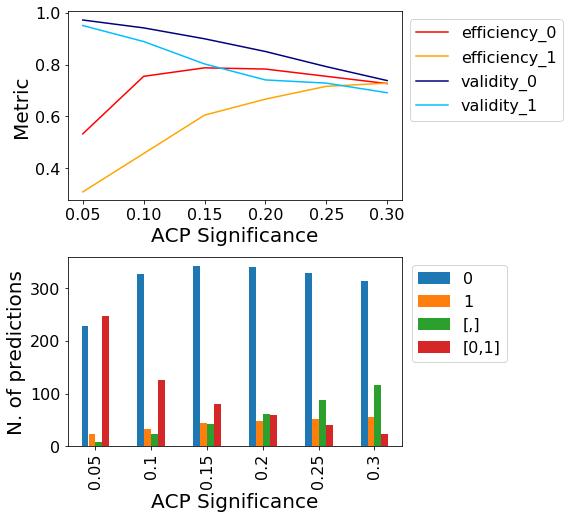

In [23]:
try_cp = True

if try_cp:
    print("--------- CP -----------")
    # calibration
    acps_cv, df_output = run_acp(train, labels_train, cv_folds = 5, nc_normalization = True, N_acp_models = 25, mol_names = names_train)
    # calculate p-values for the test set
    predict_df = predict_acp_get_pvalues(acps_cv, test, labels_test, mol_names = names_test)
    # obtain predictions of a range of significance levels and
    # calculate efficiency, validity, accuracy_rate, and accuracy. See above.
    predict_df, df_metrics = calc_CP_performance(predict_df)        
    print(df_metrics)
    # plot results
    plot_cp_results(predict_df, df_metrics, output_name = assay_id)
    df_preds = pd.merge(df_preds, predict_df, how = 'left', on = ['mol_names', 'y_true'])



The first figure shows validity and efficiency for actives (1) and inactives (0) as a function of the ACP significance level.

The second figure shows the number of compounds predicted as actives (1), inactives (0), "both" ([0,1]), and "empty" ([,]) as a function of the ACP significance level.

In [24]:
df_metrics

,significance_level,efficiency_0,efficiency_1,efficiency,validity_0,validity_1,validity,accuracy_rate_0,accuracy_rate_1,accuracy_rate,accuracy_0,accuracy_1,accuracy
0,0.05,0.532710,0.308642,0.497053,0.971963,0.950617,0.968566,0.986842,0.840000,0.972332,0.525701,0.259259,0.483301
1,0.10,0.754673,0.456790,0.707269,0.941589,0.888889,0.933202,0.990712,0.810811,0.972222,0.747664,0.370370,0.687623
2,0.15,0.787383,0.604938,0.758350,0.899533,0.802469,0.884086,0.982196,0.775510,0.955959,0.773364,0.469136,0.724951
3,0.20,0.782710,0.666667,0.764244,0.850467,0.740741,0.833006,0.973134,0.722222,0.938303,0.761682,0.481481,0.717092
4,0.25,0.754673,0.716049,0.748527,0.792056,0.728395,0.781925,0.975232,0.741379,0.939633,0.735981,0.530864,0.703340
5,0.30,0.726636,0.728395,0.726916,0.738318,0.691358,0.730845,0.971061,0.796610,0.943243,0.705607,0.580247,0.685658


In [25]:
df_preds.head()

,mol_names,y_true,standard,OobOpt,GHOST,SMOTE,RUS,p0,p1,y_pred_0.05,y_pred_0.1,y_pred_0.15,y_pred_0.2,y_pred_0.25,y_pred_0.3
0,CHEMBL3669681,0,0,1,1,1,1,0.784300,0.589281,"[0,1]","[0,1]","[0,1]","[0,1]","[0,1]","[0,1]"
1,CHEMBL3664773,0,0,0,0,0,0,0.335976,0.067061,"[0,1]",0,0,0,0,0
2,CHEMBL3664785,0,0,0,0,0,1,0.601255,0.274733,"[0,1]","[0,1]","[0,1]","[0,1]","[0,1]",0
3,CHEMBL3664785,0,0,0,0,0,1,0.603376,0.279753,"[0,1]","[0,1]","[0,1]","[0,1]","[0,1]",0
4,CHEMBL2207372,0,0,0,0,0,0,0.722791,0.012594,0,0,0,0,0,0


This table shows the predictions for the test set at different ACP significance levels. The p-values for both classification labels are also reported (p0 for inactives and p1 for actives). The predictions obtained with other rebalancing methods are also reported.


<a id='section2.3'></a>

### 2.3 Run the `run_it_` function for a single serotonin dataset




The `run_it_` function executes everything for you:

   1. **GENERATE DESCRIPTORS.** You can set the `descriptor` argument to `'MorganFP'` or `'RDKit2D'`. `'MorganFP'` corresponds to the ECFP4 descriptor, while `'RDKit2D'` is a collection of 200 topological and physico-chemical properties obtained using the descriptastorus package
   
   
   2. **TRAIN-TEST SPLIT.** A random stratified train-test split is done using the `train_test_split` function of scikit-learn
   
   
   3. **TRAIN A MACHINE LEARNING CLASSIFIER.** In this case, we train a Random Forest (RF) classifier, but the model can easily be changed in the functions `run_it2`, `run_smote`, `run_random_undersampling`, and `run_acp`.
   
   
   4. **OPTIMIZE THE DECISION THRESHOLD.** The threshold is optimized by default based on the prediction probabilities of the training subsets. The number and size of the subsets can be set using the arguments `N_subsets` and `subsets_size`, respectively. Only for the RF model, one can also optimize the decision threshold based on the out-of-bag prediction probabilities. To do this, set `opt_oob = True`.
   
   
   5. **RUN RESAMPLING METHODS OR THE BALANCED RANFOM FOREST** by setting `try_resampling = True` and `try_brf = True`, respectively

**Set Parameters:**

In [26]:
# general parameters 
assay_id = 'CHEMBL3371' #it will be returned as key of the output dictionary
d = serotonin_d
descriptor = 'MorganFP'
scale_features = False
test_set_size = 0.2
serotonin_archive=defaultdict(list)
random_seed = 28

# threshold optimization parameters:
opt_oob = True
ThOpt_metrics = 'Kappa'
thresholds = np.round(np.arange(0.05,0.55,0.05),2)
N_subsets = 100
subsets_size = 0.2
with_replacement = True

# resampling 
try_resampling = True

# brf
try_brf = False

# conformal prediction
try_cp = True


**Prepare the dataset:**

In [27]:
# Define active and inactive compounds to convert this into a classification problem
# start with a pretty strict cutoff for active/inactive:
assay = d.loc[d['target_chembl_id']==assay_id]
acts = assay.loc[assay['pchembl_value']>9.0]
if len(acts)>=50:
    inacts = assay.loc[assay['pchembl_value']<8.5]
else:
    # but relax that if we don't end up with a reasonable number of actives:
    acts = assay.loc[assay['pchembl_value']>8.0]
    inacts = assay.loc[assay['pchembl_value']<7.5]
    

**Run it all:**

--------- Default -----------
thresh: 0.50, kappa: 0.637, AUC test-set: 0.957
[[422   6]
 [ 36  45]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       428
           1       0.88      0.56      0.68        81

    accuracy                           0.92       509
   macro avg       0.90      0.77      0.82       509
weighted avg       0.92      0.92      0.91       509

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.30, kappa: 0.712, AUC test-set: 0.957
[[409  19]
 [ 20  61]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       428
           1       0.76      0.75      0.76        81

    accuracy                           0.92       509
   macro avg       0.86      0.85      0.86       509
weighted avg       0.92      0.92      0.92       509

--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.718, AUC test-set: 0.957
[[404  24]
 [ 16  65]

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.731, AUC test-set: 0.960
[[402  26]
 [ 13  68]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       428
           1       0.72      0.84      0.78        81

    accuracy                           0.92       509
   macro avg       0.85      0.89      0.87       509
weighted avg       0.93      0.92      0.93       509

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.563, AUC test-set: 0.934
[[371  57]
 [ 15  66]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       428
           1       0.54      0.81      0.65        81

    accuracy                           0.86       509
   macro avg       0.75      0.84      0.78       509
weighted avg       0.89      0.86      0.87       509

--------- CP -----------
   significance_level  efficiency_0  efficiency_1  efficiency  validity_0  \
0                0.05      0.469626      0.209877    0.428291    0.985981   
1                0.10      0.728972      0.407407    0.677800    0.955607   
2                0.15      0.747664      0.493827    0.707269    0.899533   
3                0.20      0.766355      0.641975    0.746562    0.862150   
4                0.25      0.787383      0.679012    0.770138    0.815421   
5                0.30      0.738318      0.716049    0.734774    0.757009   

   validity_1  validity  accuracy_rat

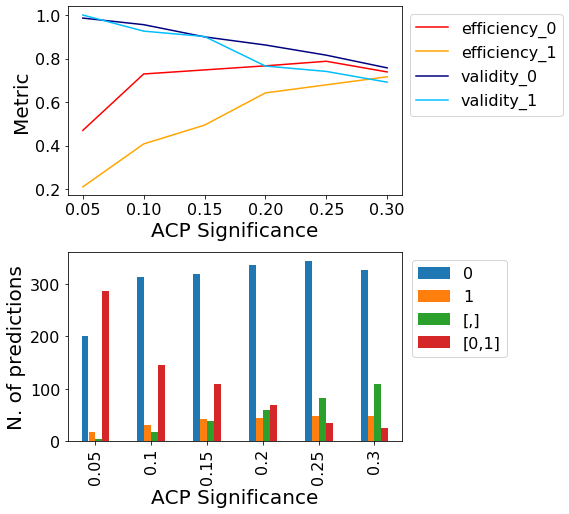

In [28]:
df_preds = run_it_(assay_id, acts, inacts, serotonin_archive, descriptor = descriptor, scale_features = scale_features, 
        test_set_size = test_set_size, random_seed = random_seed, 
        opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
        N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement, 
        try_resampling = try_resampling, try_brf = try_brf, try_cp = try_cp)

<a id='section2.4'></a>

### 2.4 Run the `run_it_` function for all serotonin datasets

Define a functions that runs the run_it_ function for all serotonin datasets:

In [29]:
def run_serotonin_assay(assay_id, d, assay_lookup, descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, try_resampling = True, try_brf = False, 
                        try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25,
                        archive=None, archive_key = None, **kwargs):
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    # these need to be converted into a classification problem.
    # start with a pretty strict cutoff for active/inactive:
    assay = d.loc[d['target_chembl_id']==assay_id]
    acts = assay.loc[assay['pchembl_value']>9.0]
    if len(acts)>=50:
        inacts = assay.loc[assay['pchembl_value']<8.5]
    else:
        # but relax that if we don't end up with a reasonable number of actives:
        acts = assay.loc[assay['pchembl_value']>8.0]
        inacts = assay.loc[assay['pchembl_value']<7.5]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, organism: {assay_lookup[assay_id][0]}, target: {assay_lookup[assay_id][1]}')
    df_preds = run_it_(archive_key, acts, inacts, archive, descriptor = descriptor, scale_features = scale_features, 
            test_set_size = test_set_size, random_seed = random_seed, 
            opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, N_subsets = N_subsets, 
            subsets_size = subsets_size, try_resampling = try_resampling, try_brf = try_brf, 
            try_cp = try_cp, cv_folds = cv_folds, nc_normalization = nc_normalization, N_acp_models = N_acp_models,
            with_replacement = with_replacement, **kwargs)
    df_preds.to_csv(f"./results/rf_{descriptor}_predictions_{assay_id}.csv", index = False)
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


Run it all:

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3371, organism: Homo sapiens, target: Serotonin 6 (5-HT6) receptor
--------- Default -----------
thresh: 0.50, kappa: 0.686, AUC test-set: 0.951
[[423   5]
 [ 32  49]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       428
           1       0.91      0.60      0.73        81

    accuracy                           0.93       509
   macro avg       0.92      0.80      0.84       509
weighted avg       0.93      0.93      0.92       509

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.30, kappa: 0.792, AUC test-set: 0.951
[[415  13]
 [ 15  66]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       428
           1       0.84      0.81      0.82        81

    accuracy                           0.94       509
   macro avg       0.90      0.89      0.90       509
weighted avg       0.94    

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.755, AUC test-set: 0.945
[[402  26]
 [ 10  71]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       428
           1       0.73      0.88      0.80        81

    accuracy                           0.93       509
   macro avg       0.85      0.91      0.88       509
weighted avg       0.94      0.93      0.93       509

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.686, AUC test-set: 0.940
[[389  39]
 [ 10  71]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       428
           1       0.65      0.88      0.74        81

    accuracy                           0.90       509
   macro avg       0.81      0.89      0.84       509
weighted avg       0.92      0.90      0.91       509

--------- CP -----------
   significance_level  efficiency_0  efficiency_1  efficiency  validity_0  \
0                0.05      0.553738      0.358025    0.522593    0.953271   
1                0.10      0.721963      0.456790    0.679764    0.911215   
2                0.15      0.754673      0.567901    0.724951    0.857477   
3                0.20      0.757009      0.629630    0.736739    0.829439   
4                0.25      0.750000      0.691358    0.740668    0.785047   
5                0.30      0.712617      0.679012    0.707269    0.731308   

   validity_1  validity  accuracy_rat

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.682, AUC test-set: 0.969
[[471  25]
 [  5  37]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       496
           1       0.60      0.88      0.71        42

    accuracy                           0.94       538
   macro avg       0.79      0.92      0.84       538
weighted avg       0.96      0.94      0.95       538

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.586, AUC test-set: 0.965
[[453  43]
 [  3  39]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       496
           1       0.48      0.93      0.63        42

    accuracy                           0.91       538
   macro avg       0.73      0.92      0.79       538
weighted avg       0.95      0.91      0.93       538

--------- CP -----------
   significance_level  efficiency_0  efficiency_1  efficiency  validity_0  \
0                0.05      0.602823      0.357143    0.583643    0.975806   
1                0.10      0.772177      0.380952    0.741636    0.945565   
2                0.15      0.800403      0.452381    0.773234    0.903226   
3                0.20      0.790323      0.500000    0.767658    0.860887   
4                0.25      0.768145      0.619048    0.756506    0.820565   
5                0.30      0.747984      0.738095    0.747212    0.776210   

   validity_1  validity  accuracy_rat

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.675, AUC test-set: 0.955
[[366  29]
 [  3  40]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       395
           1       0.58      0.93      0.71        43

    accuracy                           0.93       438
   macro avg       0.79      0.93      0.84       438
weighted avg       0.95      0.93      0.93       438

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.557, AUC test-set: 0.943
[[350  45]
 [  4  39]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.93       395
           1       0.46      0.91      0.61        43

    accuracy                           0.89       438
   macro avg       0.73      0.90      0.77       438
weighted avg       0.94      0.89      0.90       438

--------- CP -----------
   significance_level  efficiency_0  efficiency_1  efficiency  validity_0  \
0                0.05      0.632911      0.116279    0.582192    0.979747   
1                0.10      0.772152      0.209302    0.716895    0.941772   
2                0.15      0.777215      0.302326    0.730594    0.896203   
3                0.20      0.805063      0.465116    0.771689    0.883544   
4                0.25      0.741772      0.511628    0.719178    0.812658   
5                0.30      0.708861      0.511628    0.689498    0.772152   

   validity_1  validity  accuracy_rat

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


thresh: 0.35, kappa: 0.588, AUC test-set: 0.906
[[271   0]
 [  8   6]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       271
           1       1.00      0.43      0.60        14

    accuracy                           0.97       285
   macro avg       0.99      0.71      0.79       285
weighted avg       0.97      0.97      0.97       285

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.603, AUC test-set: 0.866
[[263   8]
 [  4  10]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       271
           1       0.56      0.71      0.63        14

    accuracy                           0.96       285
   macro avg       0.77      0.84      0.80       285
weighted avg       0.96      0.96      0.96       285

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.410, AUC test-set: 0.877
[[244  27]
 [  2  12]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       271
           1       0.31      0.86      0.45        14

    accuracy                           0.90       285
   macro avg       0.65      0.88      0.70       285
weighted avg       0.96      0.90      0.92       285

--------- CP -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


   significance_level  efficiency_0  efficiency_1  efficiency  validity_0  \
0                0.05      0.095941      0.000000    0.091228    0.981550   
1                0.10      0.446494      0.071429    0.428070    0.944649   
2                0.15      0.697417      0.071429    0.666667    0.911439   
3                0.20      0.771218      0.071429    0.736842    0.870849   
4                0.25      0.704797      0.285714    0.684211    0.793358   
5                0.30      0.682657      0.357143    0.666667    0.752768   

   validity_1  validity  accuracy_rate_0  accuracy_rate_1  accuracy_rate  \
0    1.000000  0.982456         0.807692              NaN       0.807692   
1    0.928571  0.943860         0.983471              0.0       0.975410   
2    0.928571  0.912281         1.000000              0.0       0.994737   
3    0.928571  0.873684         1.000000              0.0       0.995238   
4    0.714286  0.789474         1.000000              0.0       0.979487   
5   

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.574, AUC test-set: 0.874
[[161  25]
 [ 13  40]]
              precision    recall  f1-score   support

           0       0.93      0.87      0.89       186
           1       0.62      0.75      0.68        53

    accuracy                           0.84       239
   macro avg       0.77      0.81      0.79       239
weighted avg       0.86      0.84      0.85       239

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.487, AUC test-set: 0.855
[[161  25]
 [ 19  34]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       186
           1       0.58      0.64      0.61        53

    accuracy                           0.82       239
   macro avg       0.74      0.75      0.74       239
weighted avg       0.82      0.82      0.82       239

--------- CP -----------
   significance_level  efficiency_0  efficiency_1  efficiency  validity_0  \
0                0.05      0.322581      0.245283    0.305439    0.951613   
1                0.10      0.537634      0.320755    0.489540    0.940860   
2                0.15      0.672043      0.377358    0.606695    0.892473   
3                0.20      0.752688      0.490566    0.694561    0.838710   
4                0.25      0.758065      0.641509    0.732218    0.790323   
5                0.30      0.715054      0.698113    0.711297    0.725806   

   validity_1  validity  accuracy_rat

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.603, AUC test-set: 0.898
[[121  12]
 [  5  17]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       133
           1       0.59      0.77      0.67        22

    accuracy                           0.89       155
   macro avg       0.77      0.84      0.80       155
weighted avg       0.91      0.89      0.90       155

--------- RUS -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.498, AUC test-set: 0.874
[[114  19]
 [  5  17]]
              precision    recall  f1-score   support

           0       0.96      0.86      0.90       133
           1       0.47      0.77      0.59        22

    accuracy                           0.85       155
   macro avg       0.72      0.81      0.75       155
weighted avg       0.89      0.85      0.86       155

--------- CP -----------
   significance_level  efficiency_0  efficiency_1  efficiency  validity_0  \
0                0.05      0.157895      0.363636    0.187097    0.984962   
1                0.10      0.353383      0.454545    0.367742    0.947368   
2                0.15      0.571429      0.590909    0.574194    0.902256   
3                0.20      0.578947      0.590909    0.580645    0.872180   
4                0.25      0.639098      0.681818    0.645161    0.827068   
5                0.30      0.661654      0.681818    0.664516    0.774436   

   validity_1  validity  accuracy_rat

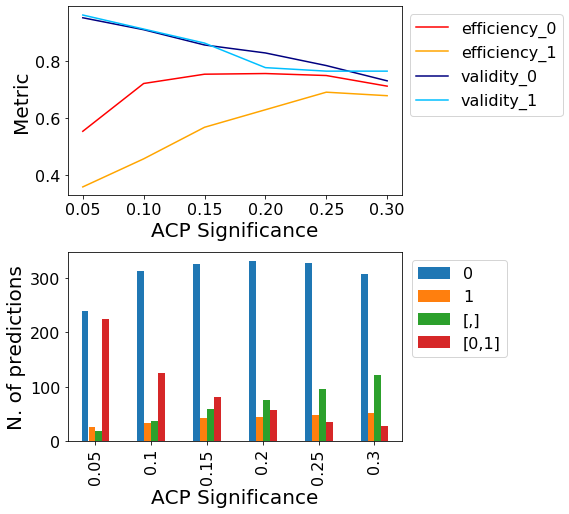

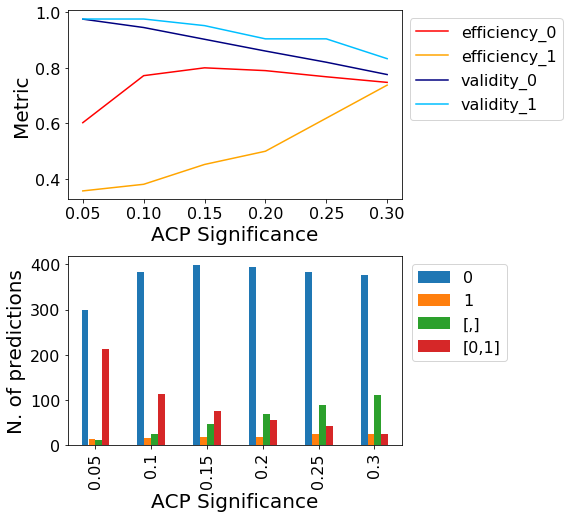

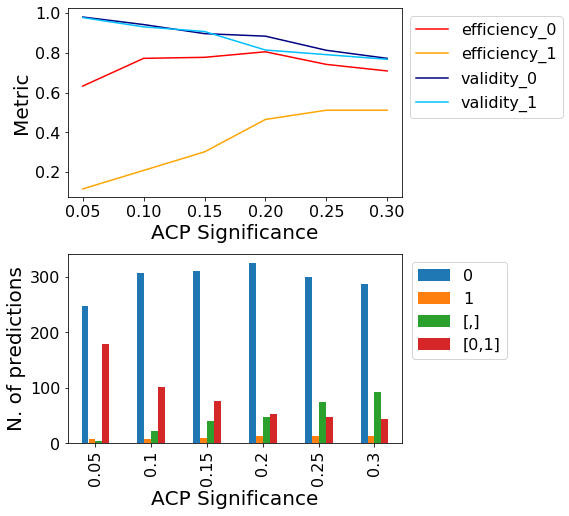

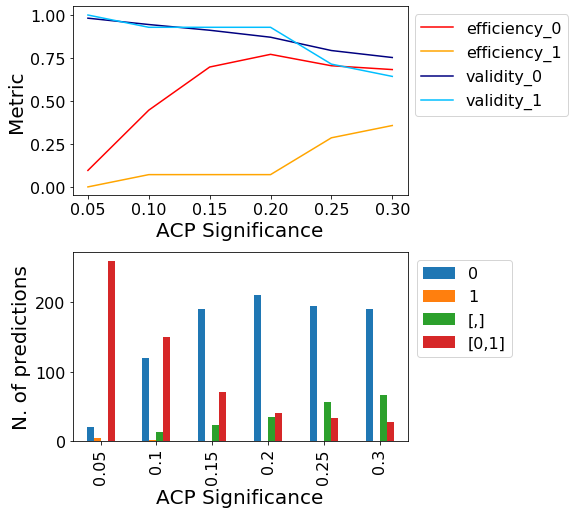

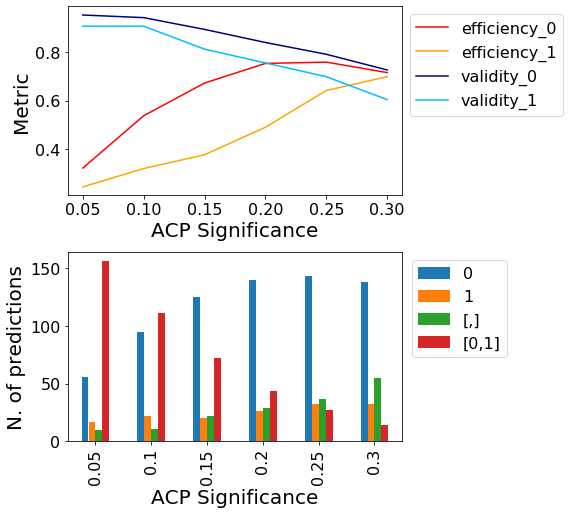

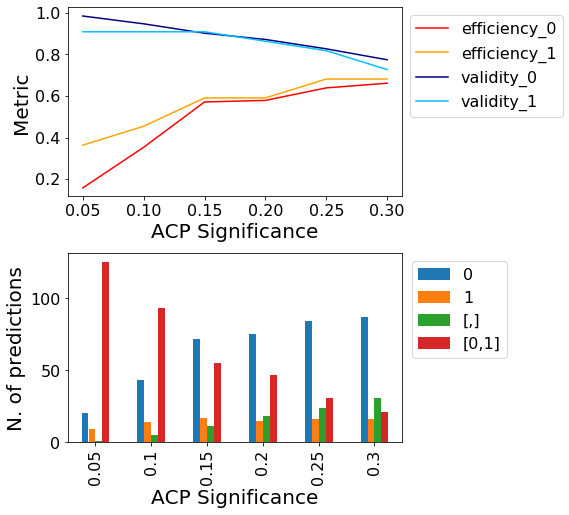

In [30]:
serotonin_archive = defaultdict(list)

for v,k in tpls:
    if v>900:
        run_serotonin_assay(k, serotonin_d, assay_lookup, descriptor = 'MorganFP', test_set_size = 0.2, 
                            ThOpt_metrics = 'Kappa', N_subsets = 100, subsets_size = 0.2, 
                            with_replacement = True, opt_oob = True,
                            archive=serotonin_archive, archive_key = k,
                            try_resampling = True, try_cp = True)


# Save Results

In [31]:
pickle.dump(serotonin_archive, open(f'results/serotonin_results_rf_{descriptor}_kappa.pkl','wb+'))


<a id='section3'></a>

# 3. Plot Results

#### Read Results

In [32]:
archive1 = pd.read_pickle(f'results/serotonin_results_rf_{descriptor}_kappa.pkl')

#### Order Results

In [33]:
def read_in_data(archive1, metric = 'Kappa'):
    if metric == 'Kappa':
        idx = 2
    elif metric == 'threshold':
        idx = 1
    elif metric == 'auc':
        idx = 4
    elif metric == 'accuracy':
        idx = 3
    df_kappa_tmp = pd.DataFrame.from_dict(archive1, orient='index')
    col_names = [x[0] for x in serotonin_archive[list(serotonin_archive.keys())[0]]]
    #col_names = [a.replace('standard', 'Th = 0.5') for a in col_names]
    #col_names = [a.replace('smote', 'SMOTE') for a in col_names]
    #col_names = [a.replace('rus', 'RUS') for a in col_names]
    df_kappa_tmp.columns = col_names
    df_kappa = df_kappa_tmp.apply(lambda x: x.str[idx])
    df_kappa['assay'] = df_kappa.index
    if metric == 'accuracy':
        df_kappa = df_kappa.applymap(calc_accuracy)
    return df_kappa


# Calculate accuracy from confusion matrix
def calc_accuracy(a):
    try:
        acc = (a[0][0] + a[1,1])/np.sum(a)
    except:
        acc = np.nan
    return acc



In [44]:
df_kappa = read_in_data(archive1, metric = 'Kappa')
df_kappa = df_kappa.reset_index().rename(columns = {'index': 'assay_id'})
df_auc = read_in_data(archive1, metric = 'auc')
df_thresholds = read_in_data(archive1, metric = 'threshold')
df_accuracy = read_in_data(archive1, metric = 'accuracy')


In [35]:
from matplotlib import cm
import matplotlib as mpl


def round_nearest(x, a):
    return round(x / a) * a


# SCATTERPLOT OF THE KAPPA OBTAINED BY TWO DIFFERENT METHODS
# df_mean1: dataframe containing the results of the first method (unbalanced)
# df_mean2: dataframe containing the results of the second method (balanced)
# df_thresh2: dataframe containing the optimized thresholds 
# df_auc: dataframe containing the calculated ROC-AUC. The ROC-AUC for the test set is in the standard/Th05 column
# xax: name of the column containing the results for method 1
# yax: name of the column containing the results for method 2
# errorbars, df_std1, df_std2: if errorbars = True and  dataframes containing the standard deviation for df_mean1 
#                              and df_mean2 are provided, then errorbars are also plotted

# COLOR according to the optimized threshold, SHAPE according to the AUC of the test set:
def scatterplot_results(df_mean1, df_mean2, df_thresh2, df_auc, 
                        xax = 'standard', yax = 'GHOST', x_lab = "$\kappa$ (Th = 0.5)", y_lab = "$\kappa$ (Th = Opt)", 
                        errorbars = False, df_std1 = None, df_std2 = None, output_name = "test", 
                        cmap = None, norm = None, transparency = 0.9, markersize = 40,
                        labels_size = 20, tick_labels_size = 18, legend_labels_size = 16, map_ticks_size = 18):
    if cmap == None:
        cmap = mpl.cm.terrain
    if norm == None:
        norm = mpl.colors.Normalize(vmin=0.05, vmax=0.5)
        
    # compare sizes of datasets
    if df_mean1.shape[0] != df_mean2.shape[0]:
        exclude = list(set(df_mean1.assay) ^ set(df_mean2.assay))
        df_mean1 = df_mean1.loc[~df_mean1.assay.isin(exclude)]
        df_mean2 = df_mean2.loc[~df_mean2.assay.isin(exclude)]
        df_thresh2 = df_thresh2.loc[~df_thresh2.assay.isin(exclude)]
        df_auc = df_auc.loc[~df_auc.assay.isin(exclude)]
        if isinstance(df_std1, pd.DataFrame):
            df_std1 = df_std1.loc[~df_std1.assay.isin(exclude)]
        if isinstance(df_std2, pd.DataFrame):
            df_std2 = df_std2.loc[~df_std2.assay.isin(exclude)]            
    # thresholds and test set auc
    thresh_round = [np.round(round_nearest(i,0.05),2) for i in list(df_thresh2[yax])]
    auc_test = np.array(list(df_auc.standard))
    # plot
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.scatter(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                marker='o', s = markersize, linewidth=0,
                c=np.array(thresh_round)[auc_test > 0.9],
                label=r'$\rm AUC$ $>$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2)
    plt.scatter(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                marker='v', s = markersize,linewidth=0, label=r'$0.8$ $<$ $\rm AUC$ $\leq$ $0.9$', 
                c=np.array(thresh_round)[(auc_test <= 0.9) & (auc_test > 0.8)],
                cmap=cmap, norm=norm, alpha = transparency, zorder = 2)
    plt.scatter(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                marker='X', s = markersize, linewidth=0, label=r'$\rm AUC$ $\leq$ $0.8$', 
                c=np.array(thresh_round)[auc_test <= 0.8],
                cmap=cmap, norm=norm, alpha = transparency, zorder = 2)
    plt.plot([0,1],[0,1],'k-', ls='--')
    plt.xlabel(x_lab, fontsize = labels_size)
    plt.ylabel(y_lab, fontsize = labels_size)
    plt.tick_params(labelsize = tick_labels_size)
    lg = plt.legend(loc = 'lower right', fontsize=legend_labels_size)
    lg.legendHandles[0].set_color('k')
    lg.legendHandles[1].set_color('k')
    lg.legendHandles[2].set_color('k')
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', )
    cbar.ax.tick_params(labelsize=map_ticks_size)
    cbar.set_label('Optimized Threshold', rotation=270, size=labels_size, labelpad=26)
    if errorbars:
        if not isinstance(df_std1, pd.DataFrame) or not isinstance(df_std2, pd.DataFrame):
            print("Error: specify df_std1 and df_std2 to plot the errorbars")
            #plt.savefig('figures/{}.png'.format(output_name), dpi=600, bbox_inches='tight')
            return
        plt.errorbar(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                     xerr = np.array(df_std1[xax])[auc_test > 0.9], yerr = np.array(df_std2[yax])[auc_test > 0.9], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                     xerr = np.array(df_std1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], yerr = np.array(df_std2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                     xerr = np.array(df_std1[xax])[auc_test <= 0.8], yerr = np.array(df_std2[yax])[auc_test <= 0.8], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
    #plt.savefig('figures/{}.png'.format(output_name), dpi=600, bbox_inches='tight')



# COLOR according to the threshold difference between method 1 and 2, SHAPE according to the AUC of the test set:
# df_thresh1: dataframe containing the thresholds used by method 1
# df_thresh2: dataframe containing the thresholds used by method 2
def scatterplot_results_th_diff(df_mean1, df_mean2, df_thresh1, df_thresh2, df_auc, 
                         xax = 'standard', yax = 'GHOST', x_lab = "$\kappa$ (Th = 0.5)", y_lab = "$\kappa$ (Th = Opt)", 
                         errorbars = False, df_std1 = None, df_std2 = None, output_name = "test", 
                         cmap = None, norm = None, transparency = 0.9, markersize = 40,
                        labels_size = 20, tick_labels_size = 18, legend_labels_size = 16, map_ticks_size = 18):
    if cmap == None:
        cmap = mpl.cm.terrain
    if norm == None:
        norm = mpl.colors.Normalize(vmin=0.0, vmax=0.1)
        
    # compare sizes of datasets
    if df_mean1.shape[0] != df_mean2.shape[0]:
        exclude = list(set(df_mean1.assay) ^ set(df_mean2.assay))
        df_mean1 = df_mean1.loc[~df_mean1.assay.isin(exclude)]
        df_mean2 = df_mean2.loc[~df_mean2.assay.isin(exclude)]
        df_thresh1 = df_thresh1.loc[~df_thresh1.assay.isin(exclude)]
        df_thresh2 = df_thresh2.loc[~df_thresh2.assay.isin(exclude)]
        df_auc = df_auc.loc[~df_auc.assay.isin(exclude)]
        if isinstance(df_std1, pd.DataFrame):
            df_std1 = df_std1.loc[~df_std1.assay.isin(exclude)]
        if isinstance(df_std2, pd.DataFrame):
            df_std2 = df_std2.loc[~df_std2.assay.isin(exclude)]            
    # thresholds and test set auc
    thresh1_round = [np.round(round_nearest(i,0.05),2) for i in list(df_thresh1[xax])]
    thresh2_round = [np.round(round_nearest(i,0.05),2) for i in list(df_thresh2[yax])]
    th_diff = list(abs(np.array(thresh1_round) - np.array(thresh2_round)))
    th_diff = [np.round(round_nearest(i,0.05),2) for i in th_diff]
    auc_test = np.array(list(df_auc.standard))
    # plot
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.scatter(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                marker='o', s = markersize, c=np.array(th_diff)[auc_test > 0.9],linewidth=0,
                label=r'$\rm AUC$ $>$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 3)
    plt.scatter(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                marker='v', s = markersize, c=np.array(th_diff)[(auc_test <= 0.9) & (auc_test > 0.8)],linewidth=0,
                label=r'$0.8$ $<$ $\rm AUC$ $\leq$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2)
    plt.scatter(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                marker='X', s = markersize, c=np.array(th_diff)[auc_test <= 0.8],linewidth=0,
                label=r'$\rm AUC$ $\leq$ $0.8$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2)
    plt.plot([0,1],[0,1],'k-', ls='--')
    plt.xlabel(x_lab, fontsize = labels_size)
    plt.ylabel(y_lab, fontsize = labels_size)
    plt.tick_params(labelsize = tick_labels_size)
    lg = plt.legend(loc = 'lower right', fontsize=legend_labels_size)
    lg.legendHandles[0].set_color('k')
    lg.legendHandles[1].set_color('k')
    lg.legendHandles[2].set_color('k')
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', ticks=[0.0, 0.05, 0.1])
    cbar.ax.tick_params(labelsize=map_ticks_size)
    cbar.set_label('Threshold Difference', rotation=270, size=labels_size, labelpad=20)
    cbar.ax.set_yticklabels(['0', '0.05', '> 0.1'])  # vertically oriented colorbar
    if errorbars:
        if not isinstance(df_std1, pd.DataFrame) or not isinstance(df_std2, pd.DataFrame):
            print("Error: specify df_std1 and df_std2 to plot error bars")
            #plt.savefig('figures/{}.png'.format(output_name), dpi=600, bbox_inches='tight')
            return
        plt.errorbar(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                     xerr = np.array(df_std1[xax])[auc_test > 0.9], yerr = np.array(df_std2[yax])[auc_test > 0.9], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                     xerr = np.array(df_std1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], yerr = np.array(df_std2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                     xerr = np.array(df_std1[xax])[auc_test <= 0.8], yerr = np.array(df_std2[yax])[auc_test <= 0.8], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
    #plt.savefig('figures/{}.png'.format(output_name), dpi=600, bbox_inches='tight')



In [36]:
# color map to display different thresholds
cmap3 = mpl.colors.LinearSegmentedColormap.from_list('custom', ['steelblue', 'paleturquoise', 'lightseagreen', 'limegreen', 'greenyellow', 'gold', 'lightyellow', 'sandybrown', 'darksalmon', 'indianred', 'saddlebrown'], N=10)
# color map to display threshold difference
cmap4 = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#27647bff', '#849fadff', '#ca3542ff'], N=3)

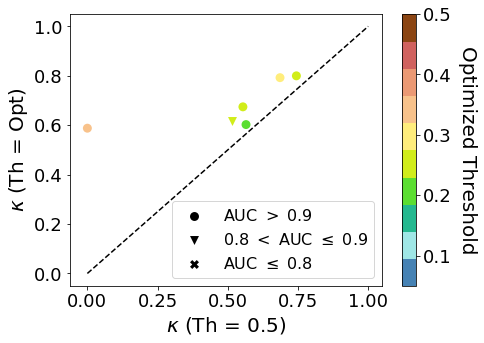

In [37]:
scatterplot_results(df_kappa, df_kappa, df_thresholds, df_auc, 
                    xax = 'standard', yax = 'GHOST', x_lab = "$\kappa$ (Th = 0.5)", y_lab = "$\kappa$ (Th = Opt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = "./figures/scatterplot_serotonin_RF_ECFP4_ThOpt_vs_Th05.png", 
                    cmap = cmap3, norm = None, transparency = 1, markersize = 80)

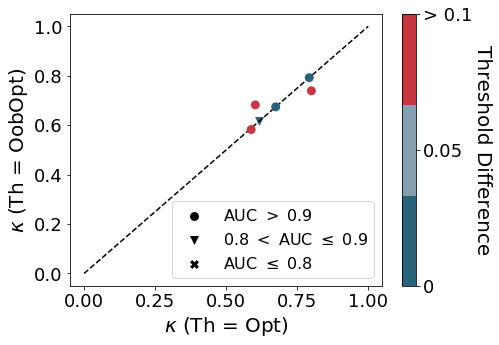

In [38]:
scatterplot_results_th_diff(df_kappa, df_kappa, df_thresholds, df_thresholds, df_auc, 
                    xax = 'GHOST', yax = 'OobOpt', x_lab = "$\kappa$ (Th = Opt)", y_lab = "$\kappa$ (Th = OobOpt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = "./figures/scatterplot_serotonin_RF_ECFP4_ThOpt_vs_ThOob.png", 
                    cmap = cmap4, norm = None, transparency = 1, markersize = 80)

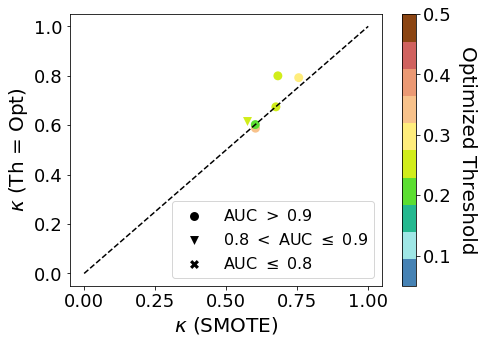

In [39]:
scatterplot_results(df_kappa, df_kappa, df_thresholds, df_auc, 
                    xax = 'SMOTE', yax = 'GHOST', x_lab = "$\kappa$ (SMOTE)", y_lab = "$\kappa$ (Th = Opt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = "./figures/scatterplot_serotonin_RF_ECFP4_ThOpt_vs_Th05.png", 
                    cmap = cmap3, norm = None, transparency = 1, markersize = 80)

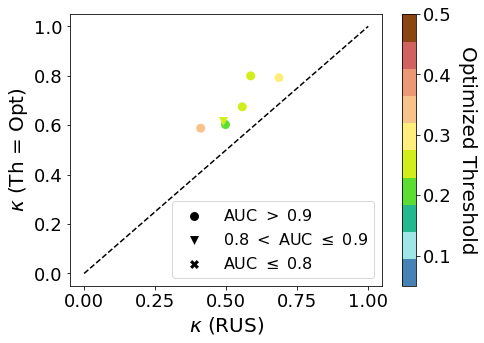

In [40]:
scatterplot_results(df_kappa, df_kappa, df_thresholds, df_auc, 
                    xax = 'RUS', yax = 'GHOST', x_lab = "$\kappa$ (RUS)", y_lab = "$\kappa$ (Th = Opt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = "./figures/scatterplot_serotonin_RF_ECFP4_ThOpt_vs_Th05.png", 
                    cmap = cmap3, norm = None, transparency = 1, markersize = 80)

### Compare to CP

In [41]:
import glob
files_preds = glob.glob(f"results/rf_{descriptor}_predictions_*.csv")
ACP_significance_level = 0.2

**Comparison between generalized threshold optimization and CP.**

For a fair comparison, in the plot below, we compare only the predictions where CP produced statistically significant results (at a ACP significance level of 0.2):

In [45]:
assay_ids = []
kappa_cp = [] 
kappa_cp_single = [] 
kappa_th05_single = []
kappa_thopt_single = []
for f1 in files_preds:
    assay_ids.append(f1.split('_')[3].replace('.csv',''))
    df_preds1 = pd.read_csv(f1)
    df_preds1['uncertain_CP'] = 0
    df_preds1['uncertain_CP'][df_preds1['p1'] >= df_preds1['p0']] = 1
    tmp = df_preds1.loc[(df_preds1[f'y_pred_{ACP_significance_level}']=="0") | (df_preds1[f'y_pred_{ACP_significance_level}']=="1")]
    kappa_cp_single.append(metrics.cohen_kappa_score(tmp.y_true,tmp.uncertain_CP))
    kappa_th05_single.append(metrics.cohen_kappa_score(tmp.y_true,tmp.standard))
    kappa_thopt_single.append(metrics.cohen_kappa_score(tmp.y_true,tmp.GHOST))
    

df_cp = pd.DataFrame({'assay_id': assay_ids, 'CP_single': kappa_cp_single, 'Th05_single':kappa_th05_single, 
                      'GHOST_single': kappa_thopt_single})
df_kappa_cp = pd.merge(df_kappa, df_cp, how = 'left', on = 'assay_id')

df_kappa_cp.head()

,assay_id,standard,OobOpt,GHOST,SMOTE,RUS,assay,CP_single,Th05_single,GHOST_single
0,CHEMBL3371,0.685944,0.792372,0.792372,0.755315,0.685878,CHEMBL3371,0.860868,0.869319,0.870958
1,CHEMBL224,0.744254,0.739144,0.799762,0.681933,0.586320,CHEMBL224,0.924239,0.924239,0.924239
2,CHEMBL214,0.553797,0.674282,0.674282,0.674969,0.556589,CHEMBL214,0.801118,0.801118,0.801118
3,CHEMBL3155,0.000000,0.582441,0.587852,0.603064,0.410191,CHEMBL3155,0.000000,0.000000,0.000000
4,CHEMBL225,0.513352,0.617256,0.617256,0.573855,0.487374,CHEMBL225,0.560592,0.534878,0.560592


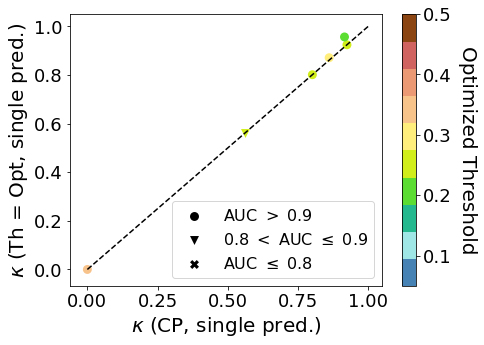

In [46]:
scatterplot_results(df_kappa_cp, df_kappa_cp, df_thresholds.rename(columns = {'GHOST': 'GHOST_single'}), df_auc, 
                    xax = 'CP_single', yax = 'GHOST_single', x_lab = "$\kappa$ (CP, single pred.)", y_lab = "$\kappa$ (Th = Opt, single pred.)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = "./figures/scatterplot_serotonin_RF_ECFP4_ThOpt_vs_CP.png", 
                    cmap = cmap3, norm = None, transparency = 1, markersize = 80)